# Initial Conditions Optimization
## Plot History

In [204]:
%matplotlib inline
import matplotlib
matplotlib.font_manager._rebuild()
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.style as style
style.use('fivethirtyeight')
import ray
import io
import os
from IPython.display import display, HTML, Markdown
from datetime import date
from datetime import datetime

## Load PlayFair Display and Roboto Fonts from Google

In [205]:
from tempfile import NamedTemporaryFile
import urllib.request
import matplotlib.font_manager as fm

github_url = 'https://github.com/google/fonts/blob/master/ofl/playfairdisplay/static/PlayfairDisplay-Regular.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
heading_font = fm.FontProperties(fname=f.name, size=28)

github_url = 'https://github.com/google/fonts/blob/master/apache/roboto/static/Roboto-Regular.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
subtitle_font = fm.FontProperties(fname=f.name, size=20)


## Load Humor Sans Font

In [206]:
# github_url = 'http://antiyawn.com/uploads/Humor-Sans-1.0.ttf'
# github_url = 'https://github.com/ipython/xkcd-font/blob/master/xkcd-script/font/xkcd-script.ttf'
github_url = 'https://github.com/ipython/xkcd-font/blob/master/xkcd/build/xkcd-Regular.otf'
# github_url = 'https://github.com/shreyankg/xkcd-desktop/blob/master/Humor-Sans.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
comic_font = fm.FontProperties(fname=f.name, size=18)

# Main code

In [207]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

## Load Initial Parameters

In [208]:
dfparam = pd.read_csv("data/param.csv")
display(dfparam)


country start-date  prediction-range          s0      e0      a0   i0   r0  \
0  Brazil     3/2/20               200  10000000.0  0.0001  0.0001  200  100   
1   China    1/28/20               200     50000.0  0.0001  0.0001  200  100   
2   Italy    2/28/20               200   2000000.0  0.0001  0.0001  200  100   
3      US    2/20/20               200  20000000.0  0.0001  0.0001  200  100   
4   India    3/10/20               200  10000000.0  0.0001  0.0001  200  100   

   d0  START  WCASES  WREC  
0  50     50    0.15  0.05  
1  50     50    0.15  0.05  
2  50     50    0.15  0.05  
3  50     50    0.15  0.05  
4  50     50    0.15  0.05

## Select data set

In [209]:
opt=0

#select history file version, model and states

if opt==0:
    #improved range for s0,i0,d0 and weights
    #increased delta startdate +-3
    version="003"
    model="Yabox"
    countries=dfparam.country

In [210]:
strFile="results/IC_optimizedCountries"+version+".csv"
if os.path.isfile(strFile):
    os.remove(strFile)

## Plot Parameters Function

In [211]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def plotParams(country,model,histMin,paramList,paramListNames,version):
        
    #prepare plotting
    color_bg = '#FEF1E5'
    lighter_highlight = '#FAE6E1'
    darker_highlight = '#FBEADC'

    histShow=histMin.nsmallest(20, ['gtot']).sort_values('gtot',ignore_index=True,ascending=False)

    with plt.xkcd():

        fig, host = plt.subplots(figsize=(15, 10),facecolor=color_bg)
        fig.subplots_adjust(right=0.75)
        host.patch.set_facecolor(darker_highlight)

        plt.rc('font', size=16)        

        #fonts for the thicks
        for label in (host.get_xticklabels() + host.get_yticklabels()):
            label.set_fontproperties(comic_font)
            label.set_fontsize(16) # Size here overrides font_prop

        par1 = host.twinx()
        par2 = host.twinx()
        par3 = host.twinx()

        # Offset the right spine of par2.  The ticks and label have already been
        # placed on the right by twinx above.
        par2.spines["right"].set_position(("axes", 1.1))
        par3.spines["right"].set_position(("axes", 1.2))


        # Having been created by twinx, par2 has its frame off, so the line of its
        # detached spine is invisible.  First, activate the frame but make the patch
        # and spines invisible.
        make_patch_spines_invisible(par2)
        make_patch_spines_invisible(par1)
        make_patch_spines_invisible(par3)

        # Second, show the right spine.
        par2.spines["right"].set_visible(True)
        par2.spines["right"].set_color("white")
        par2.spines["right"].set_linewidth(2)  
        par2.spines["right"].set_linestyle((0,(3,3)))   
        par2.spines["right"].set_capstyle("butt")

        par3.spines["right"].set_visible(True)
        par3.spines["right"].set_color("white")
        par3.spines["right"].set_linewidth(2)  
        par3.spines["right"].set_linestyle((0,(3,3)))   
        par3.spines["right"].set_capstyle("butt")

    # # Hide the left, right and top spines
        host.spines['top'].set_visible(False)
        host.spines['right'].set_visible(False)
        host.spines['left'].set_visible(False)

        p1 = histShow.reset_index().plot(x='index',y=paramList[0],ax=host, style="b-")
        p2 = histShow.reset_index().plot(x='index',y=paramList[1],ax=par1, style="r-")
        p3=  histShow.reset_index().plot(x='index',y=paramList[2],ax=par2, style="g-")
        p4=  histShow.reset_index().plot(x='index',y=paramList[3],ax=par3, style="m-")


    #     host.set_xlim(0, 2000)
        host.set_ylim(0, histShow[paramList[0]].max()*1.5)
        par1.set_ylim(0, histShow[paramList[1]].max()*1.5)
        par2.set_ylim(0, histShow[paramList[2]].max()*1.5)
        par3.set_ylim(0, histShow[paramList[3]].max()*1.5)

        host.set_xlabel("Direction of Convergence")
        host.set_ylabel(paramListNames[0])
        par1.set_ylabel(paramListNames[1])
        par2.set_ylabel(paramListNames[2])
        par3.set_ylabel(paramListNames[3])

        host.legend().remove()    
        par1.legend().remove()   
        par2.legend().remove()  
        par3.legend().remove()  

        line_labels = [paramList[0], paramList[1], paramList[2], paramList[3]]

        plt.subplots_adjust(top=1.2)    

#         fig.legend([p1, p2, p3, p4])    # The line objects
                   
        fig.legend(labels=line_labels,   # The labels for each line
                   loc=(0.6, 0.68),   # Position of legend
                   borderaxespad=0.1,    # Small spacing around legend box
                   title="Initial Conditions",  # Title for the legend
                   frameon=False
                   )

        host.grid(True, linestyle='--', linewidth=2, color='white',alpha=0.1)
        
        # Adding a title and a subtitle
        plt.text(x = 0.02, y = 1.25, s = "Parameters History - "+country,
                    fontsize = 34, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                    fontproperties=heading_font)
        plt.text(x = 0.02, y = 1.20,
                    s = "optimization by "+model,
                    fontsize = 26, alpha = .85,transform=ax.transAxes, 
                    fontproperties=subtitle_font)
        

        fig.tight_layout(pad=0.5)
        strFile ='./results/parameters'+country+versionStr+'.png'
        fig.savefig(strFile, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())

        plt.show()

## Plot and Save Results

# Results for Brazil

gtot  startdate  startNcases        s0  i0   d0  wcases    wrec
519  7.854885e+08 2020-03-05          149  14760588  33  121  0.2823  0.1813

## 5 Lowest Results

gtot  startdate  startNcases        s0   i0   d0  wcases    wrec
519  7.854885e+08 2020-03-05          149  14760588   33  121  0.2823  0.1813
541  1.072780e+09 2020-03-01          143  59068751   99  222  0.2246  0.0054
228  3.684435e+09 2020-03-02          112   8429086   32  177  0.3008  0.1118
73   4.820764e+09 2020-03-05           16   8334216   43    9  0.0864  0.0011
32   5.469637e+09 2020-03-03            9   8446416  203   80  0.2033  0.1080

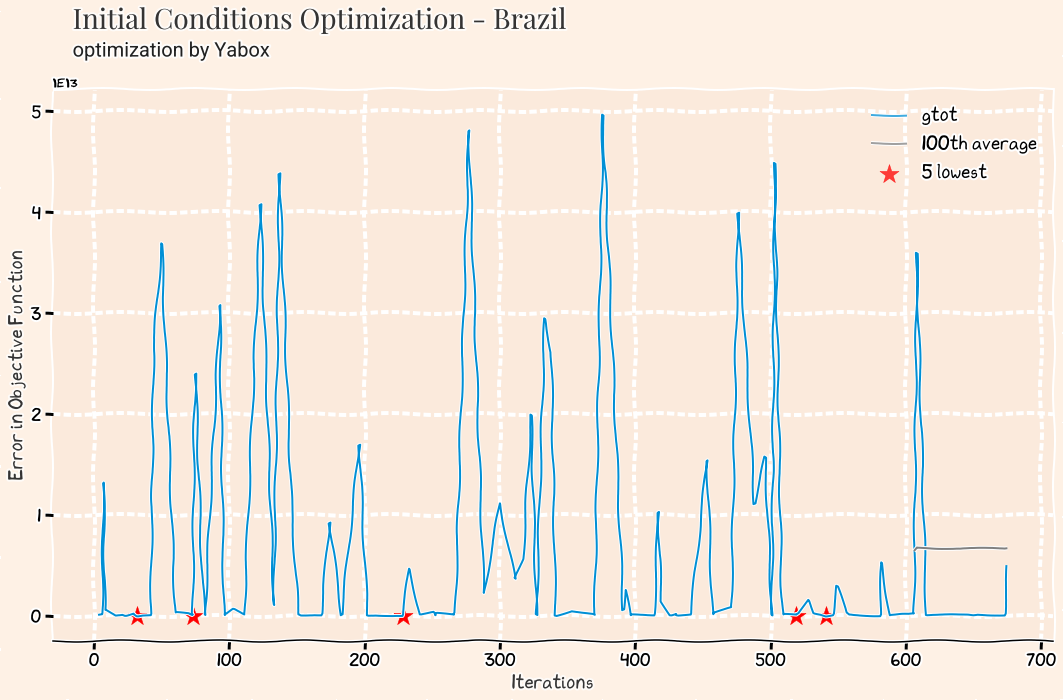

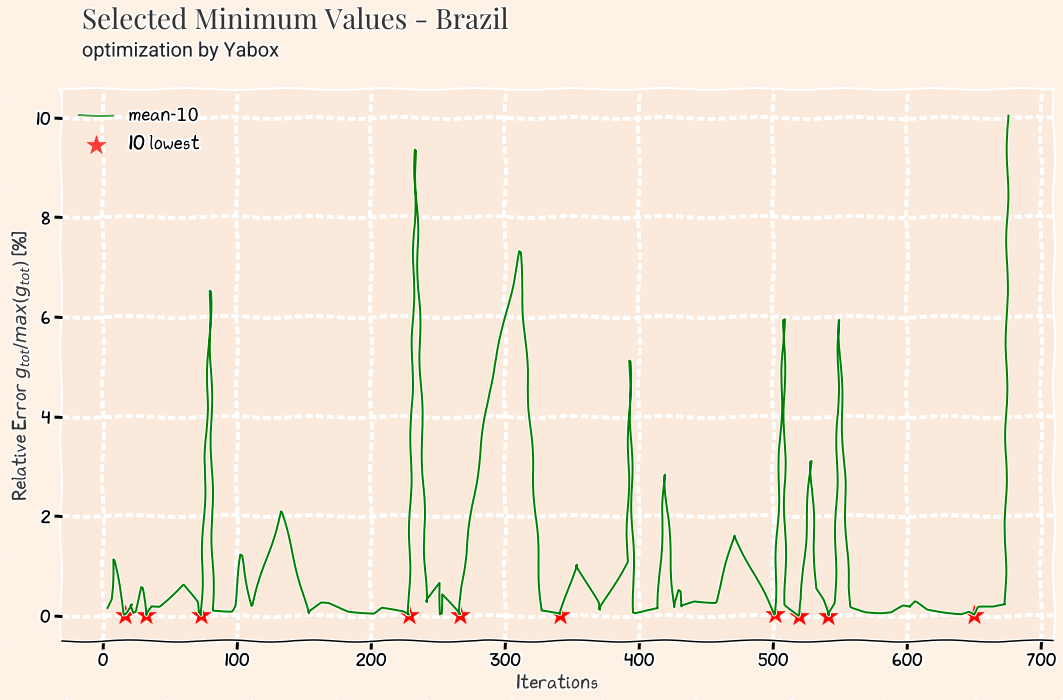

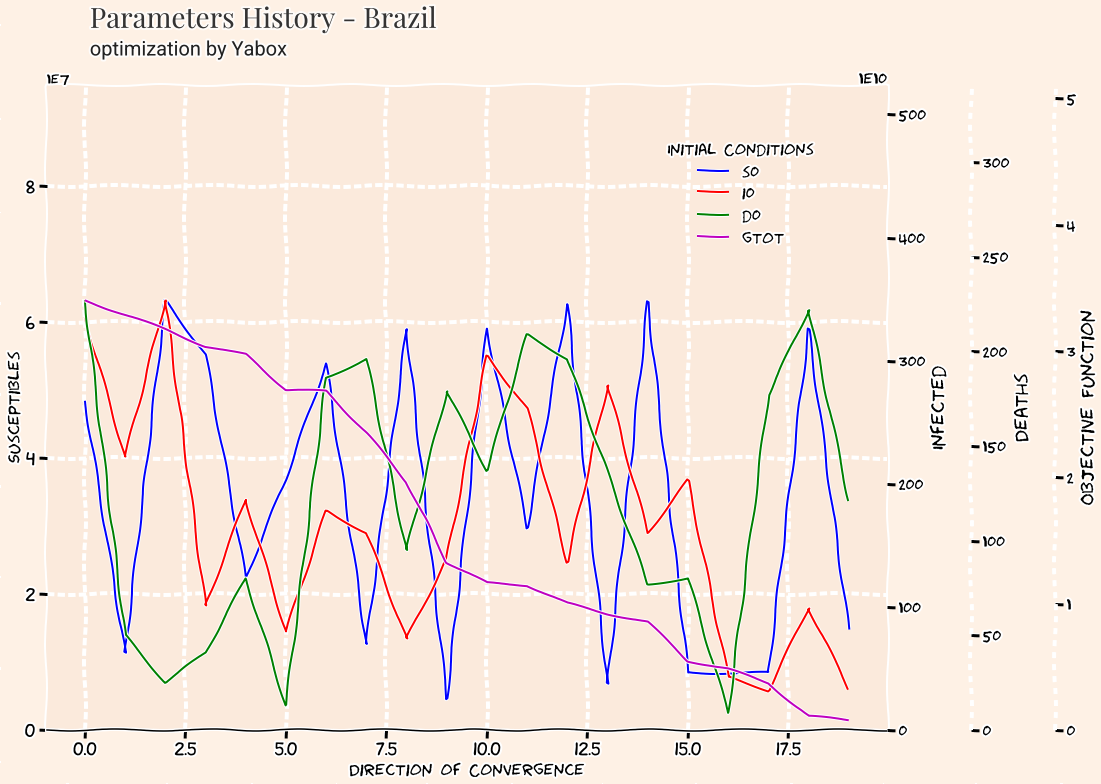

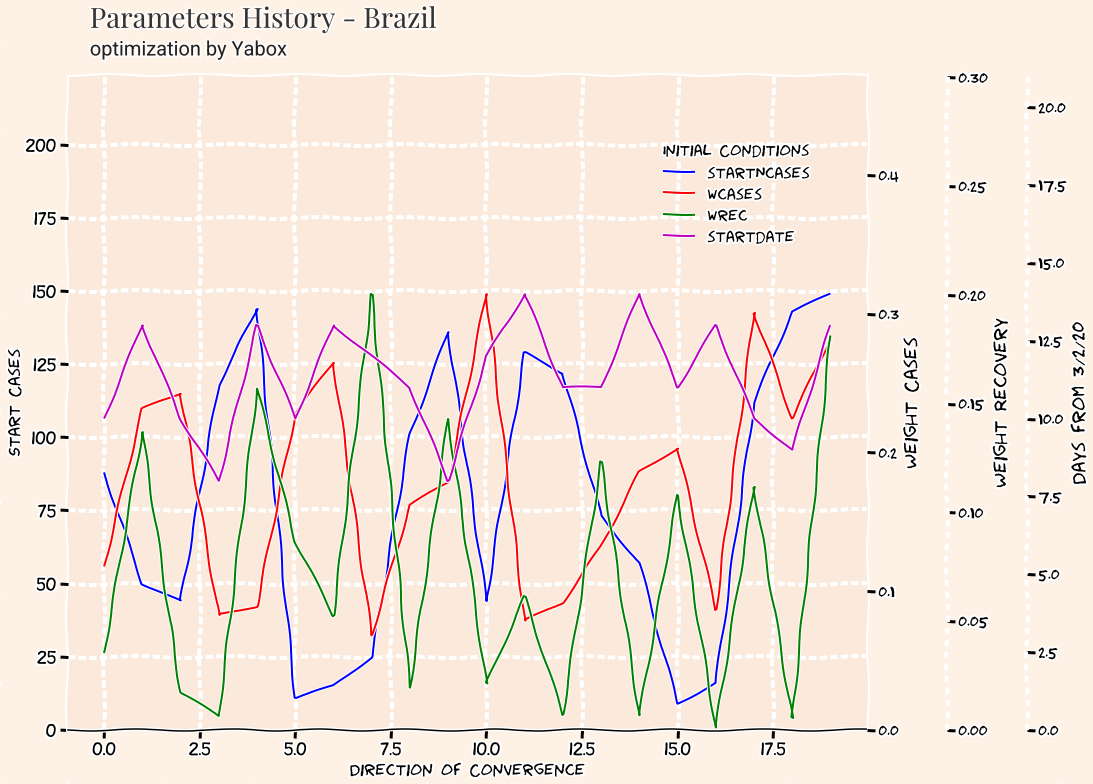

# Results for China

gtot  startdate  startNcases      s0  i0   d0  wcases    wrec
609  1.159540e+07 2020-01-27           99  391756   2  178   0.253  0.2059

## 5 Lowest Results

gtot  startdate  startNcases         s0   i0   d0  wcases    wrec
609  1.159540e+07 2020-01-27           99     391756    2  178  0.2530  0.2059
133  3.602913e+07 2020-01-26          121  105257633  135  202  0.0626  0.0030
2    4.086991e+07 2020-02-01            0  195914695   36  217  0.0616  0.0043
116  5.295568e+07 2020-01-29           30  158117481  146   82  0.0532  0.0070
131  9.353777e+07 2020-01-27          107  426240904  159  201  0.0676  0.0146

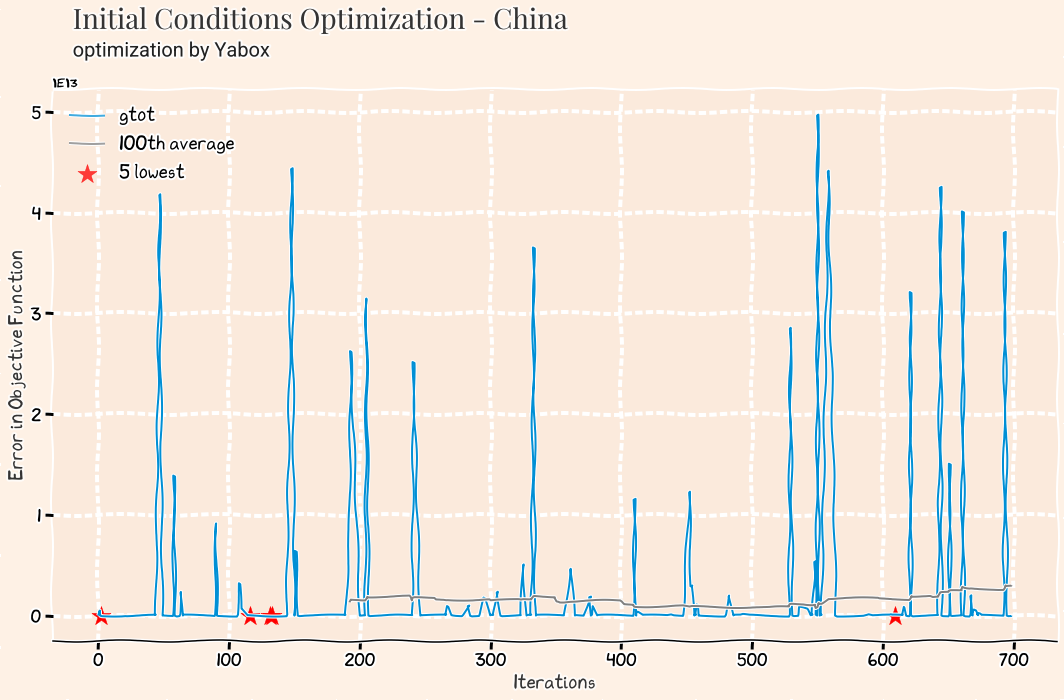

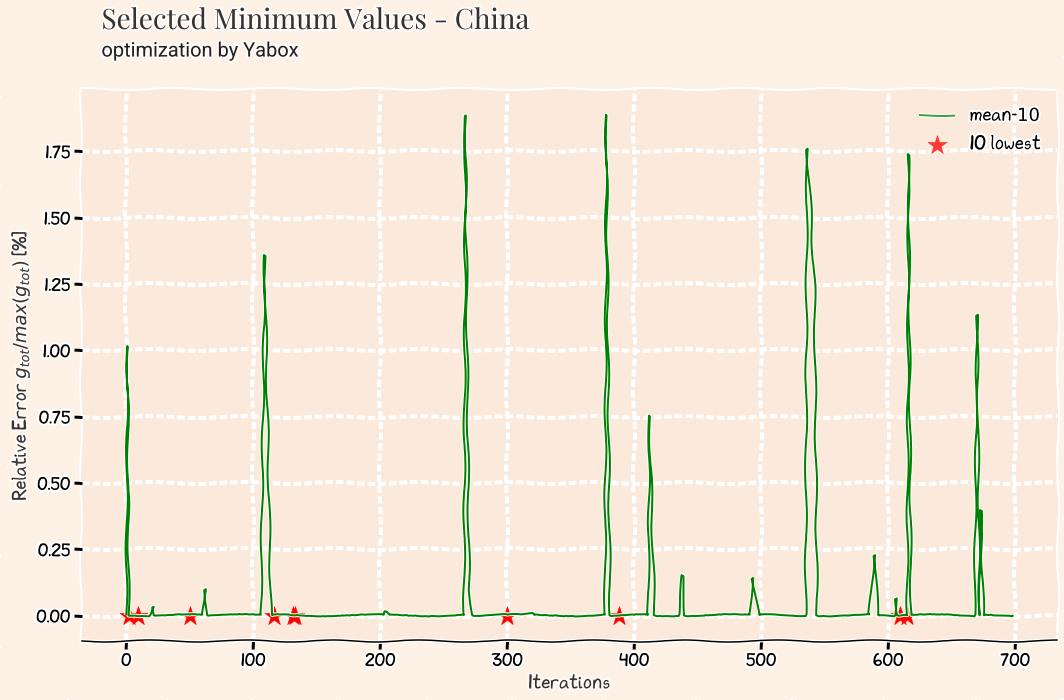

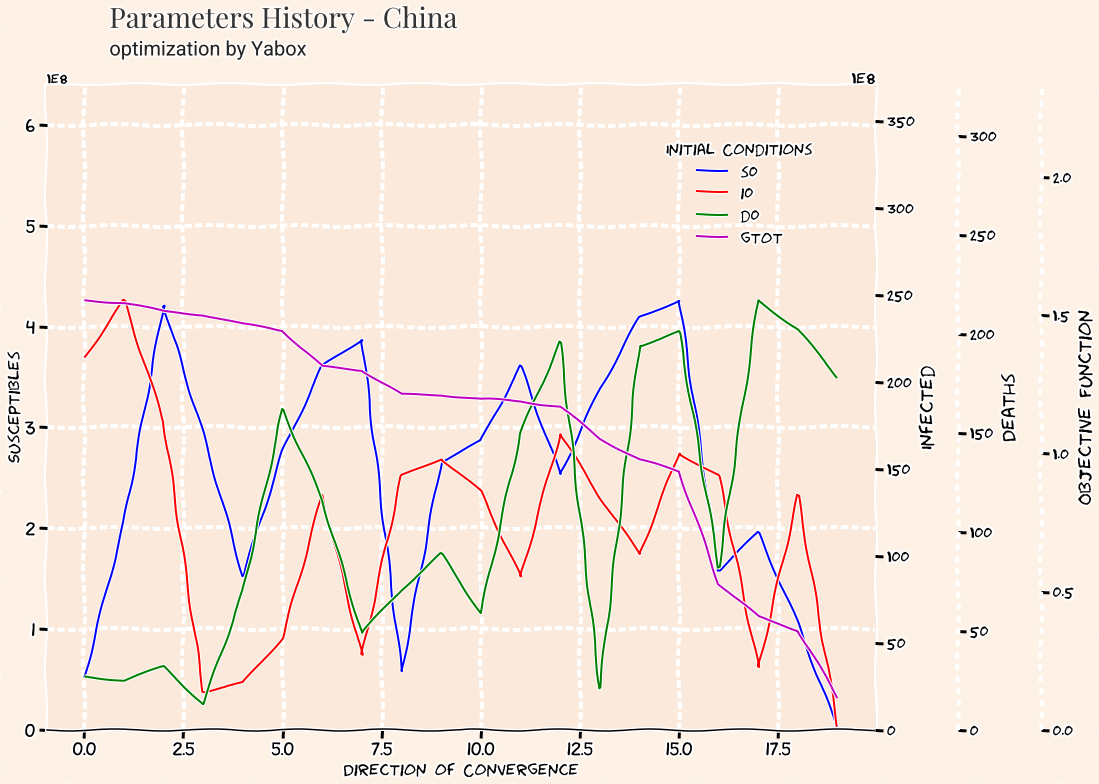

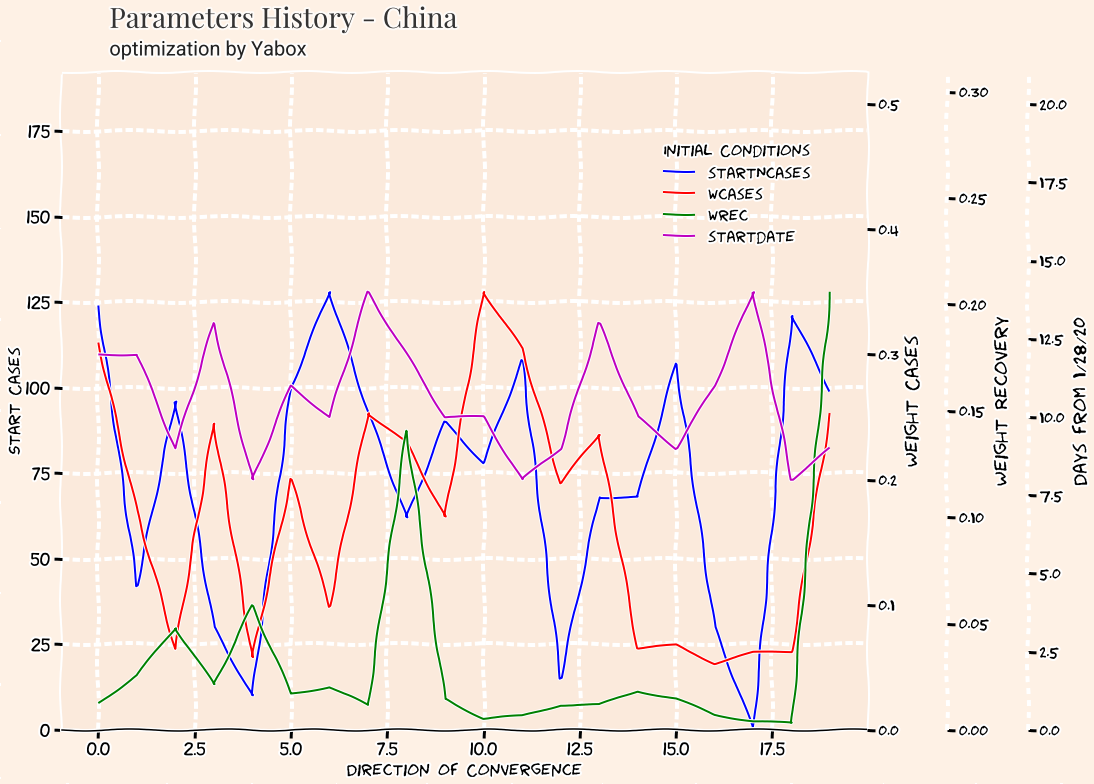

# Results for Italy

gtot  startdate  startNcases        s0  i0  d0  wcases    wrec
320  9.458669e+07 2020-02-29           86  16218500   6  94  0.0847  0.0276

## 5 Lowest Results

gtot  startdate  startNcases        s0   i0   d0  wcases    wrec
320  9.458669e+07 2020-02-29           86  16218500    6   94  0.0847  0.0276
89   1.899773e+08 2020-03-03           31   3052631  294  191  0.0930  0.0353
619  2.367363e+08 2020-03-01          130    515070  241    9  0.3315  0.0883
509  2.582393e+08 2020-02-28           10  13224412  175   75  0.2449  0.1184
38   4.521656e+08 2020-02-28          121    277072   12  168  0.3358  0.0409

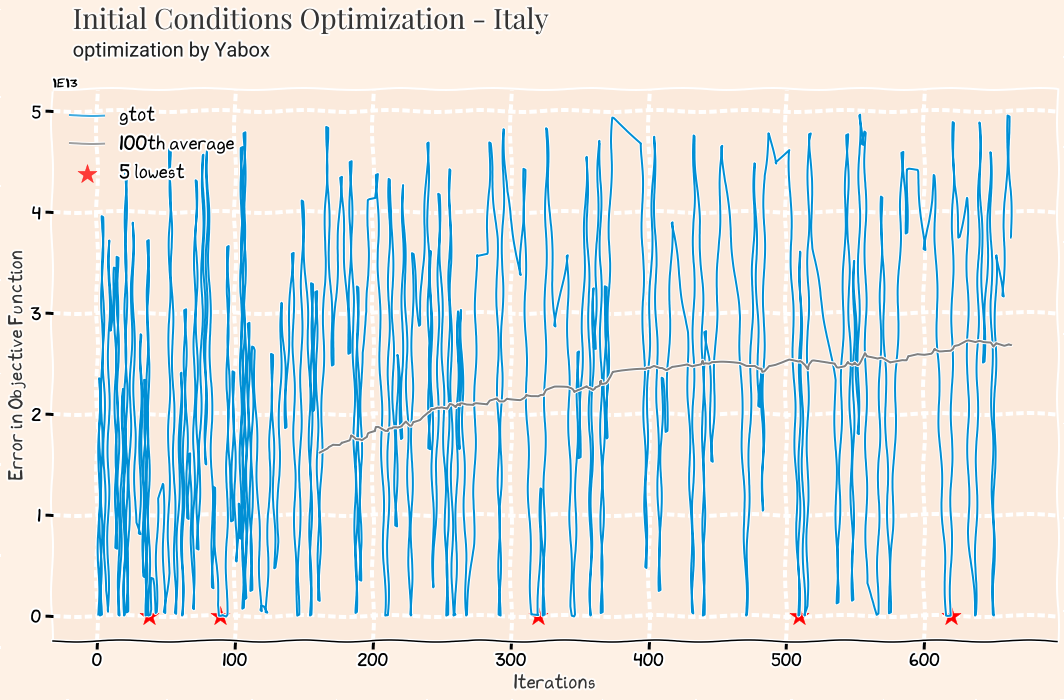

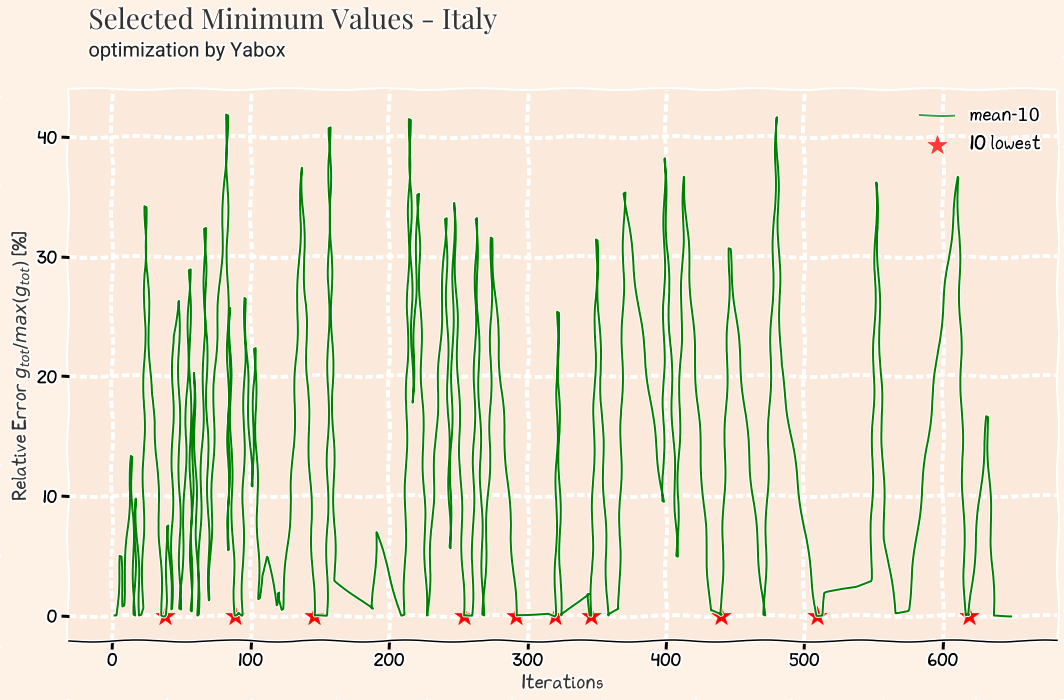

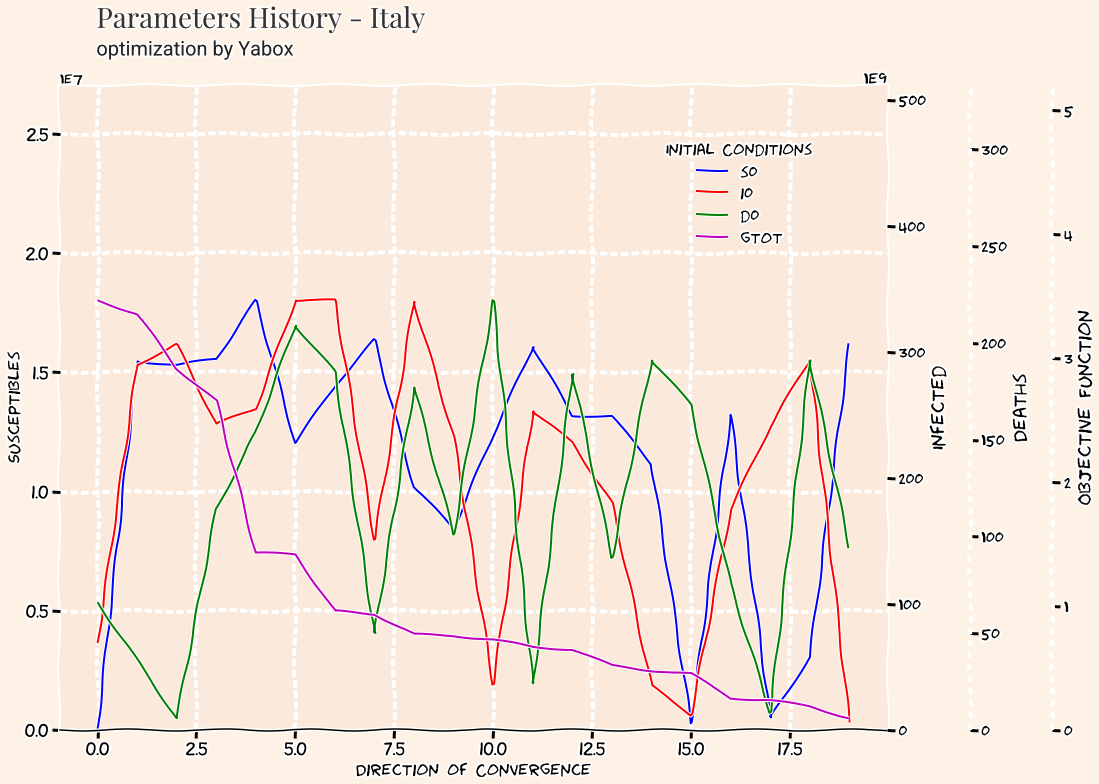

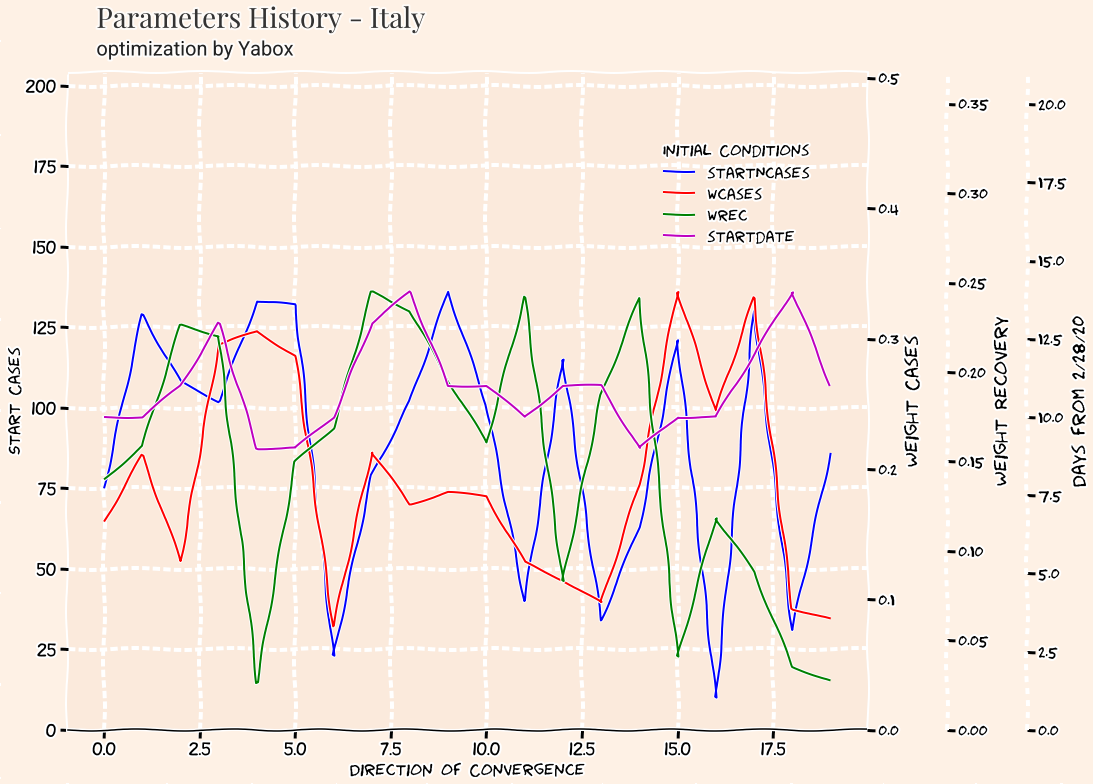

# Results for US

gtot  startdate  startNcases        s0   i0   d0  wcases    wrec
272  1.689307e+10 2020-02-22           24  85527338  209  185  0.2523  0.1744

## 5 Lowest Results

gtot  startdate  startNcases        s0   i0   d0  wcases    wrec
272  1.689307e+10 2020-02-22           24  85527338  209  185  0.2523  0.1744
389  5.768157e+10 2020-02-18           66  87468661  299  148  0.0816  0.1103
594  5.871448e+10 2020-02-19          122  79172584  224  206  0.1083  0.0753
649  5.954207e+10 2020-02-21           78  78778211  206  230  0.0693  0.0707
475  6.439151e+10 2020-02-19           93  68618172   41  119  0.2178  0.0471

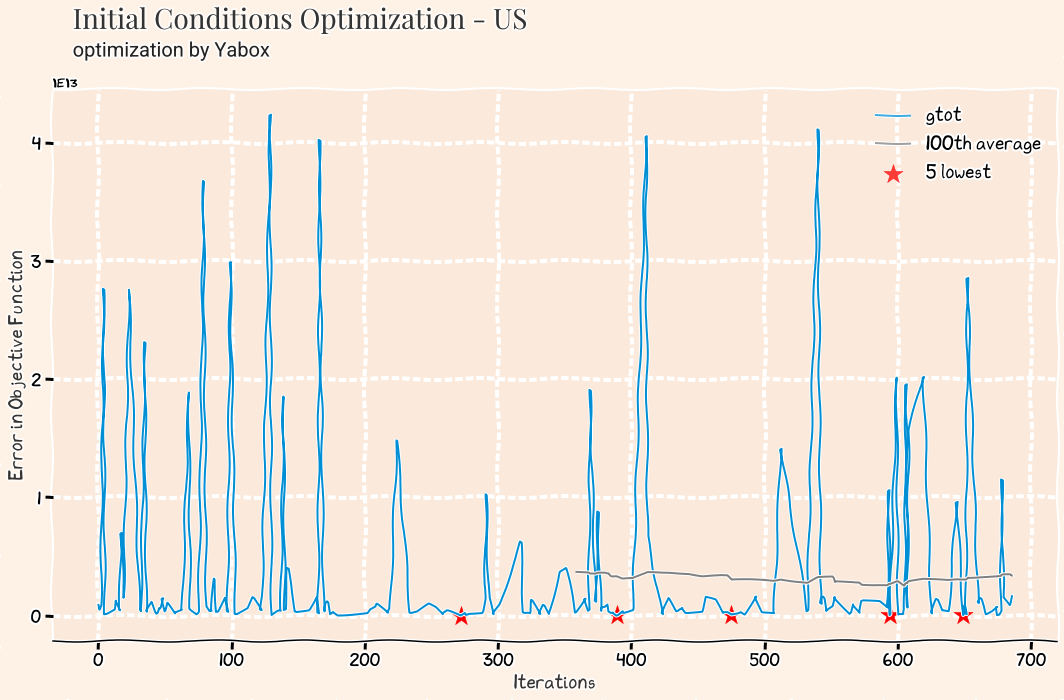

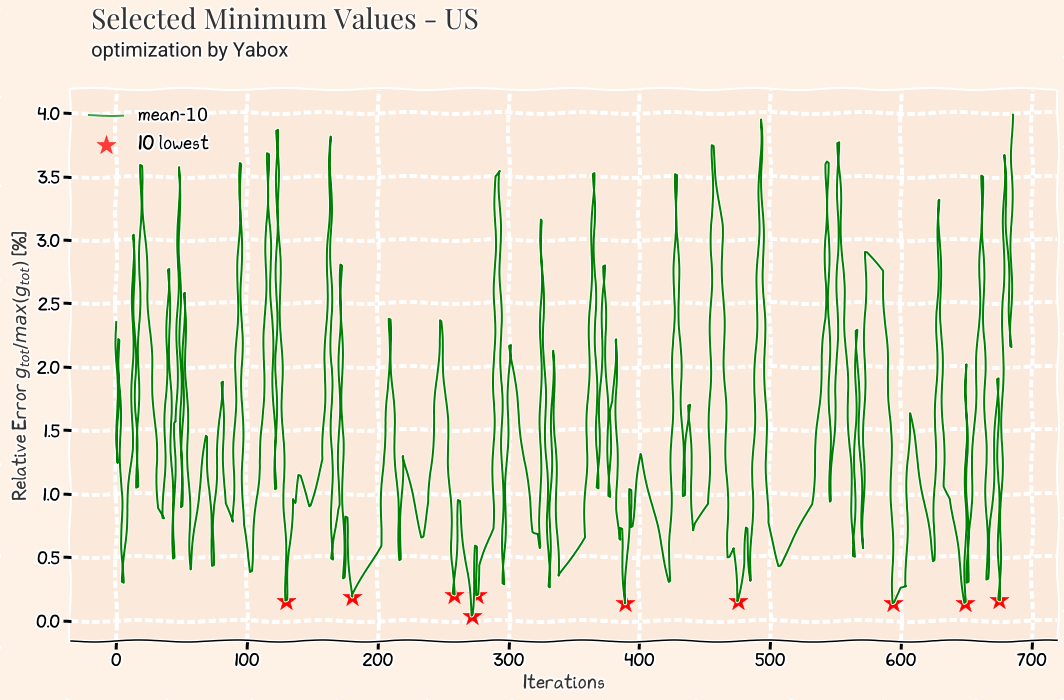

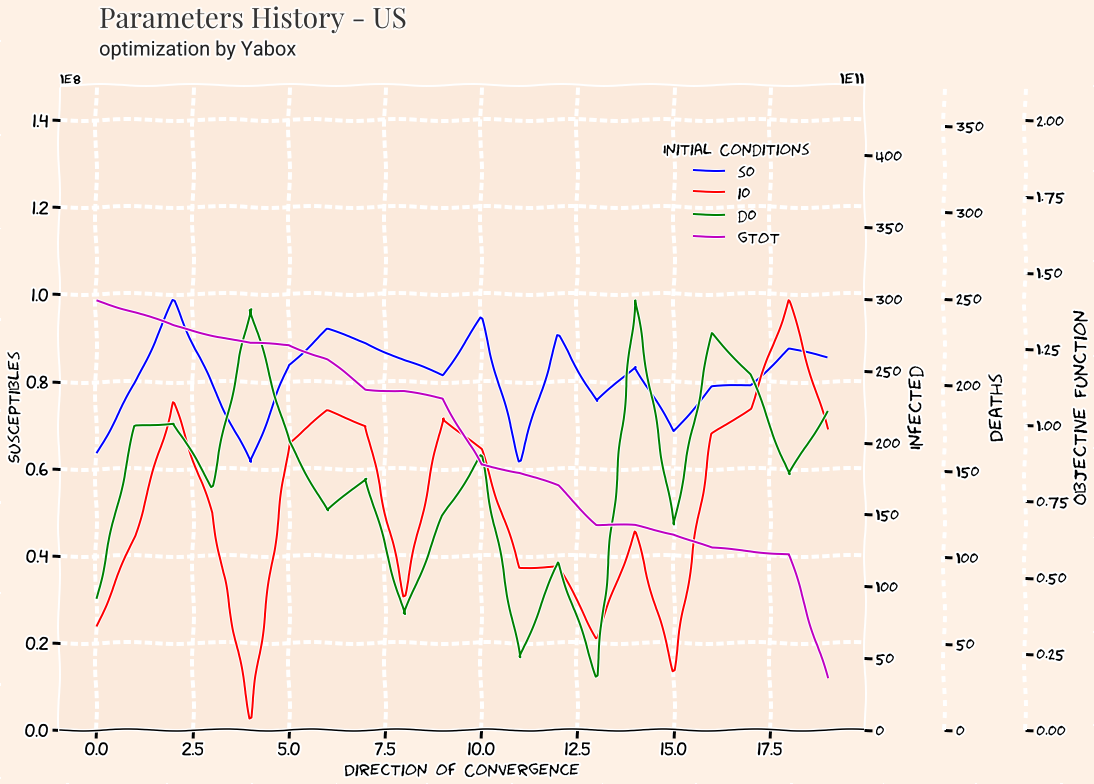

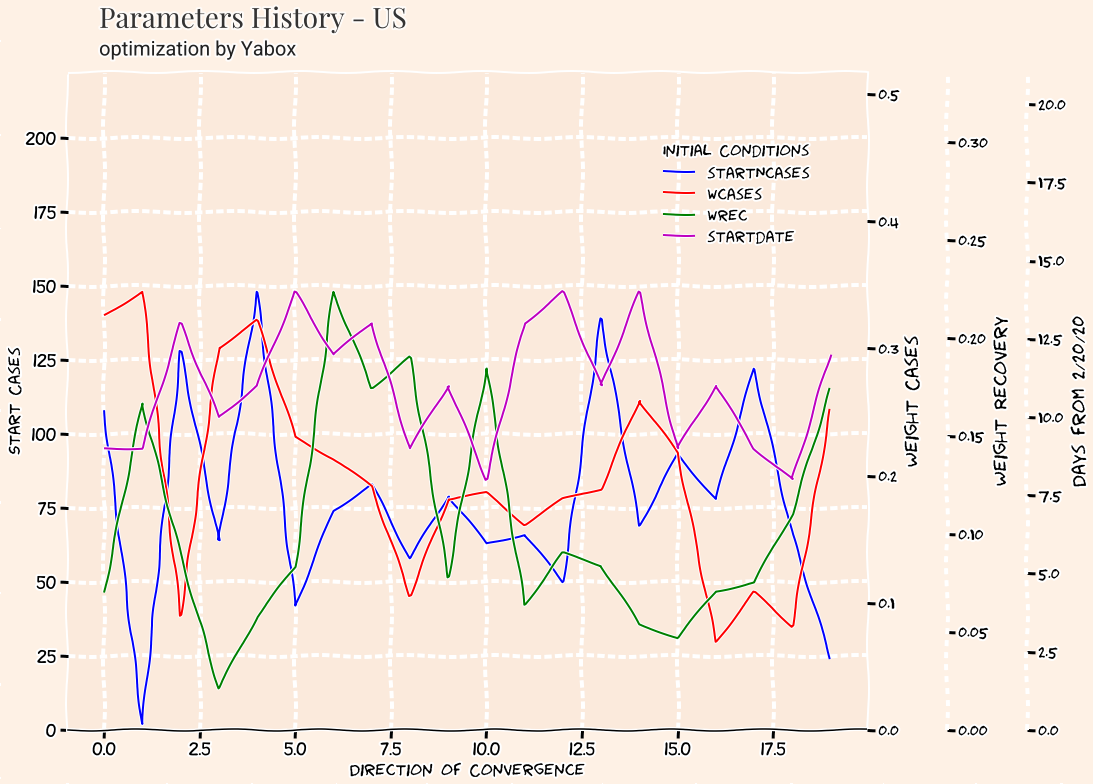

# Results for India

gtot  startdate  startNcases       s0  i0   d0  wcases    wrec
39  2.326605e+10 2020-03-12          131  9021768  11  154   0.234  0.2332

## 5 Lowest Results

gtot  startdate  startNcases         s0   i0   d0  wcases    wrec
39   2.326605e+10 2020-03-12          131    9021768   11  154  0.2340  0.2332
128  2.354190e+10 2020-03-09            8  226789436  260  210  0.1744  0.1438
380  3.516856e+10 2020-03-11          135  333240343  151   52  0.2830  0.0054
548  3.725576e+10 2020-03-11           49  347118643  122  234  0.1259  0.1050
611  3.969595e+10 2020-03-08            9  258910725  137    4  0.0773  0.0378

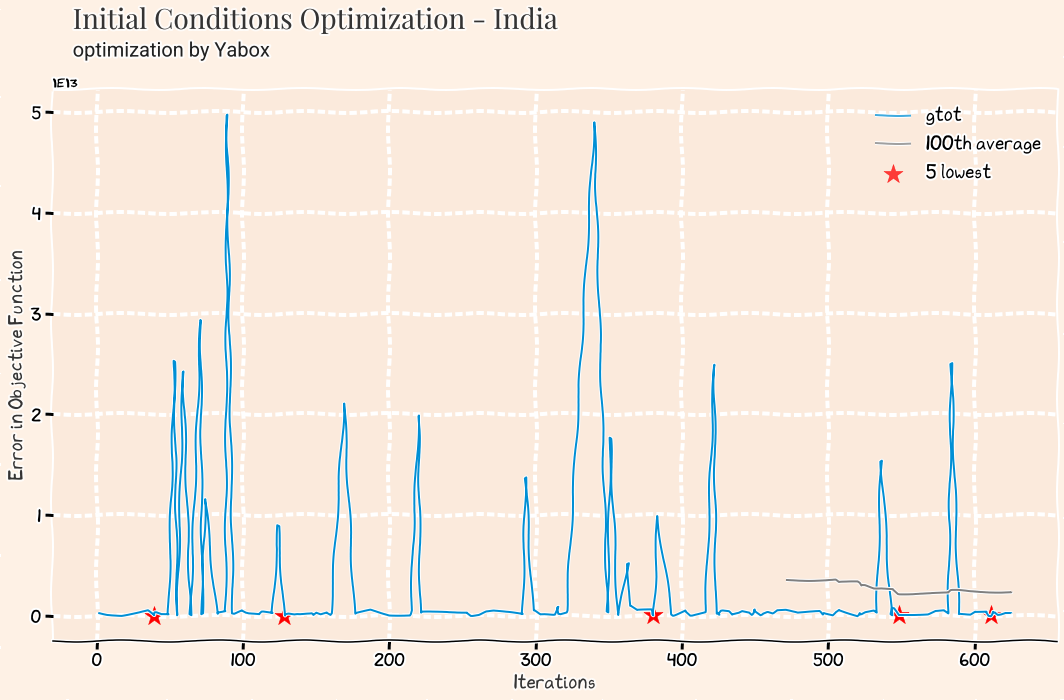

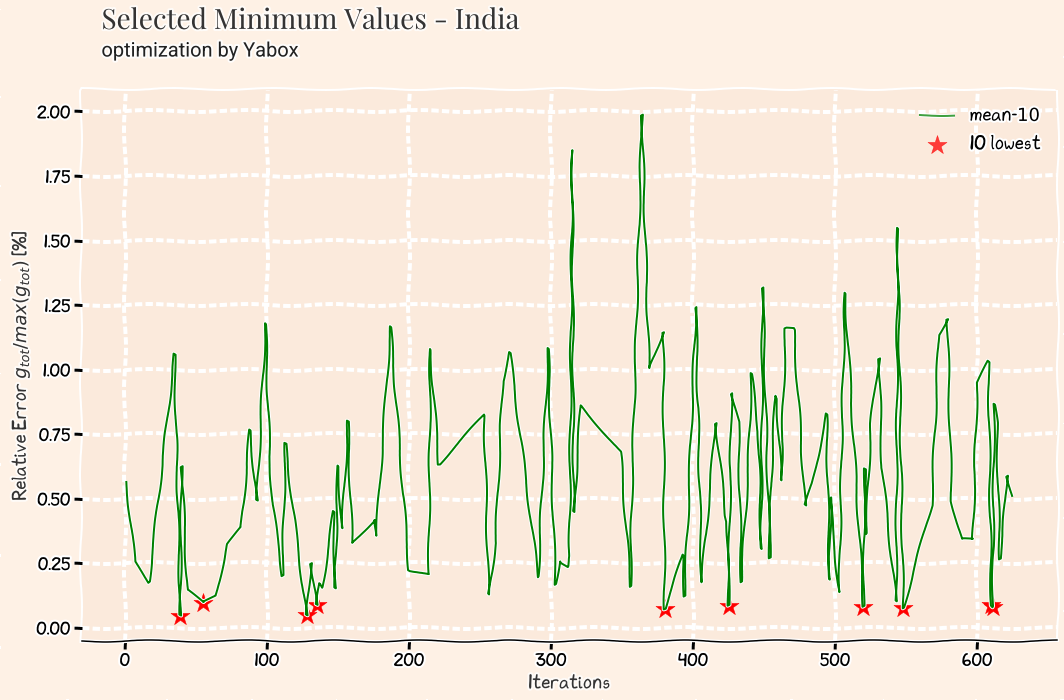

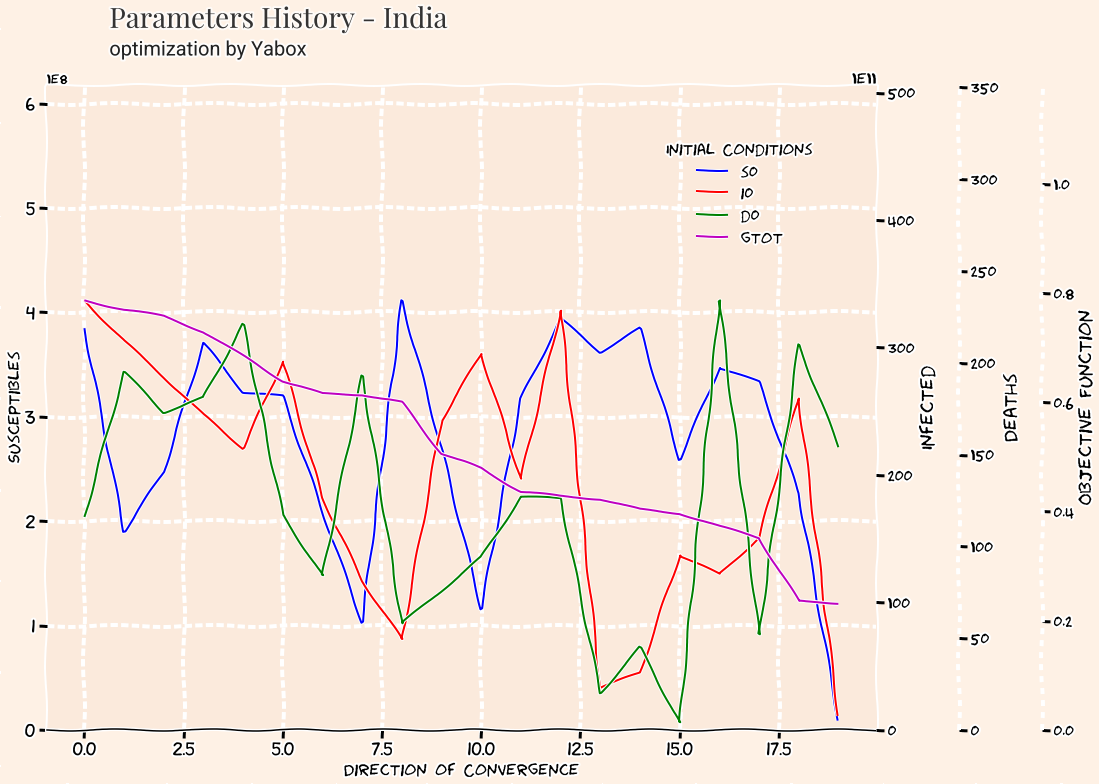

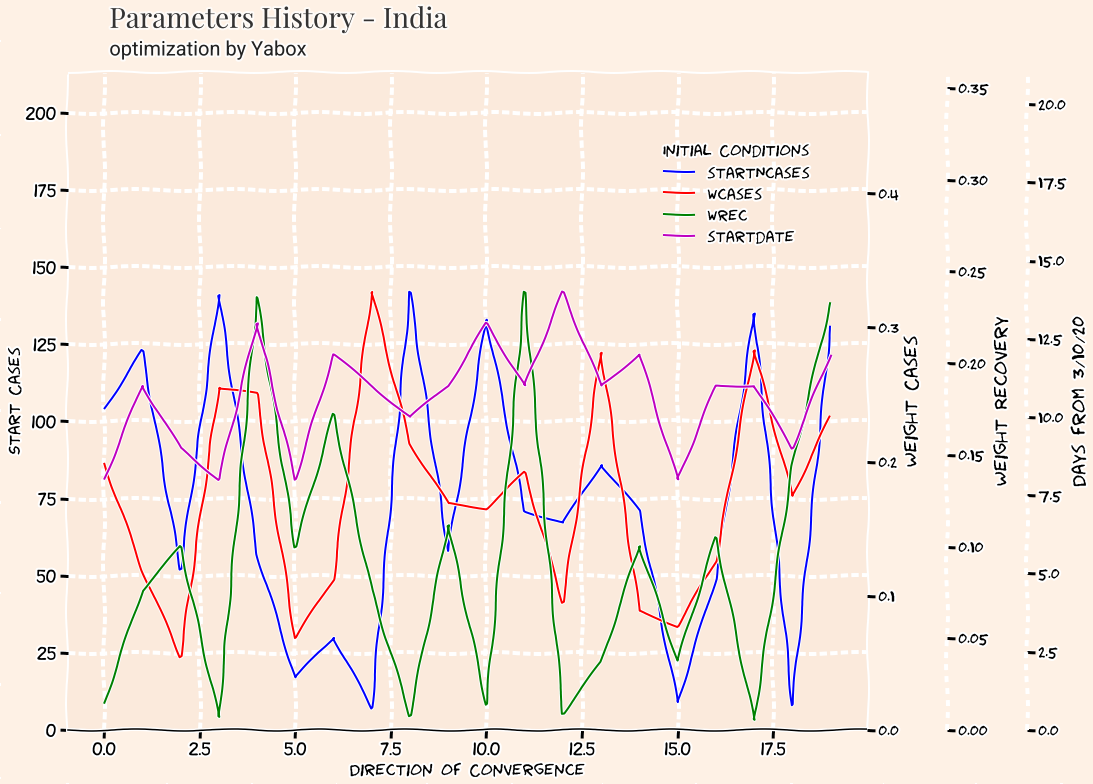

In [212]:
ggtot=[]
for country in countries:
    versionStr=version
    dateparse = lambda x: datetime.strptime(x, ' %m/%d/%y')
    histOptAll= pd.read_table('./results/history_'+country+versionStr+'.csv', sep=",", \
                                index_col=0, header=None, parse_dates=[3], date_parser=dateparse,
        names = ["country","gtot",\
            "s0","startdate","i0","d0","startNcases","wcases","wrec"])
    histOptAll = histOptAll[['gtot', 'startdate','startNcases','s0',"i0","d0","wcases","wrec"]]
        
    #clean data
    histOptAll=histOptAll.dropna(how='all')
    histOptAll.gtot=pd.to_numeric(histOptAll.gtot, errors='coerce')
    histOptAll = histOptAll.reset_index(drop=True)
    histOptAll = histOptAll[histOptAll.loc[:,"gtot"]<0.5e14]
    
    #format integers and decimal places
    histOptAll['d0'] = histOptAll['d0'].apply(lambda x: int(x+0.5))
    histOptAll['startNcases'] = histOptAll['startNcases'].apply(lambda x: int(x+0.5))
    histOptAll['s0'] = histOptAll['s0'].apply(lambda x: int(x+0.5))
    histOptAll['i0'] = histOptAll['i0'].apply(lambda x: int(x+0.5))
    histOptAll['wcases'] = histOptAll['wcases'].apply(lambda x: round(x,4))
    histOptAll['wrec'] = histOptAll['wrec'].apply(lambda x: round(x,4))
    
    #print optimum parameters
    histOpt=histOptAll[histOptAll.gtot==min(histOptAll.gtot)]
    histOpt=histOpt.head(1)
    display(Markdown("# Results for "+country))
    display(histOpt.iloc[:,0:8])
    histOpt.to_csv("data/vars_optimized_"+country+model+"HistMin.csv", sep=","
                   , index=False)
        
    #current parameters
    query = dfparam.query('country == "{}"'.format(country)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    if len(parameters)>12:
        date,predict_range,s0,e0,a0,i0,r0,d0,startNCases,wcases,wrec,popEst = parameters
    else:
        date,predict_range,s0,e0,a0,i0,r0,d0,startNCases,wcases,wrec = parameters
    
    #query parameters
    j = query['index'].values[0]
    
    #define s0, i0 and d0
    dfparam.at[j, "s0"] = histOpt.s0
    dfparam['s0'] = dfparam['s0'].astype(int)
    dfparam.at[j, "i0"] = histOpt.i0
    dfparam['i0'] = dfparam['i0'].astype(int)
    dfparam.at[j, "d0"] = histOpt.d0
    dfparam.at[j, "START"] = histOpt.startNcases
    
    dfparam['a0'] = dfparam['a0'].astype(int)
    dfparam['e0'] = dfparam['e0'].astype(int)
    dfparam['r0'] = dfparam['r0'].astype(int)
    dfparam['d0'] = dfparam['d0'].astype(int)
    #define Start N Cases
    dfparam['START'] = dfparam['START'].astype(int)
    #define date, wcases, wrec
    dfparam.at[j, "start-date"] = histOpt.startdate.dt.strftime('%m/%d/%y').values[0]
    dfparam.at[j, "WCASES"] = histOpt.wcases
    dfparam.at[j, "WREC"] = histOpt.wrec
    
    dfparam.r0=0
    
    #save new parameters
    dfparam.to_csv("data/param_optimized_"+model+"_HistMin.csv", sep=",", index=False)
    
    ggtot.append(histOpt.gtot.values[0])
    
    #prepare plotting
    color_bg = '#FEF1E5'
    # lighter_highlight = '#FAE6E1'
    darker_highlight = '#FBEADC'
    plt.rc('font', size=14)
    
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
        ax.patch.set_facecolor(darker_highlight)
        
        #fonts for the thicks
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(comic_font)
            label.set_fontsize(16) # Size here overrides font_prop
        
        #labels for x and y axis
        plt.xlabel("Iterations", fontproperties=comic_font, alpha = .75)
        plt.ylabel("Error in Objective Function", fontproperties=comic_font, alpha = .75)
        
        # Hide the left, right and top spines
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        #PLOTTING itself
        x=histOptAll.index
        y=histOptAll.gtot
        ax.plot(x,y, label="gtot")
        display(Markdown("## 5 Lowest Results"))
        histMin=histOptAll.nsmallest(5, ['gtot']).sort_values('gtot').iloc[:,0:8]
        display(histMin)

        ax.scatter(histMin.index, histMin.gtot,label="5 lowest",c='red',marker='*',s=400)
        histOptAll.rolling(100).mean()['gtot'].plot(label="100th average",c='gray')

        # Adding a title and a subtitle
        plt.text(x = 0.02, y = 1.11, s = "Initial Conditions Optimization - "+country,
                    fontsize = 34, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                    fontproperties=heading_font)
        plt.text(x = 0.02, y = 1.06,
                    s = "optimization by "+model,
                    fontsize = 26, alpha = .85,transform=ax.transAxes, 
                    fontproperties=subtitle_font)
        
        leg=ax.legend(frameon=False,prop=comic_font,fontsize=16)
        for lh in leg.legendHandles: 
            lh.set_alpha(0.75)
        ax.grid(True, linestyle='--', linewidth='2', color='white',alpha=0.1)

        fig.tight_layout()
        strFile ='./results/convergence_'+country+versionStr+'.png'
        fig.savefig(strFile, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())
        plt.show()
        
        fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
        ax.patch.set_facecolor(darker_highlight)
        
        # Hide the left, right and top spines
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        #fonts for the thicks
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(comic_font)
            label.set_fontsize(16) # Size here overrides font_prop
        
        histMin=histOptAll.iloc[:,0:8]
        histMin.sort_index(inplace=True)
        
        histMin['error']=histMin.gtot/histMin.gtot.max()*100
        x=histMin.index[histMin.error<(histMin.error.mean()-0.1*histMin.error.std())]
        y=histMin.error[histMin.error<(histMin.error.mean()-0.1*histMin.error.std())]
                
        ax.plot(x, y, label="mean-$10\% \cdot \sigma$",c='green')
        histMin2=histMin.nsmallest(10, ['gtot']).sort_values('gtot')
        ax.scatter(histMin2.index, histMin2.gtot/histMin.gtot.max()*100,
                   label="10 lowest",c='red',marker='*',s=400)
        
        #labels for x and y axis
        plt.xlabel("Iterations", fontproperties=comic_font, alpha = .75)
        plt.ylabel("Relative Error $g_{tot}/max(g_{tot})$ [%]", 
                   fontproperties=comic_font, alpha = .75)

        # Adding a title and a subtitle
        plt.text(x = 0.02, y = 1.11, s = "Selected Minimum Values - "+country,
                    fontsize = 34, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                    fontproperties=heading_font)
        plt.text(x = 0.02, y = 1.06,
                    s = "optimization by "+model,
                    fontsize = 26, alpha = .85,transform=ax.transAxes, 
                    fontproperties=subtitle_font)
        
        leg=ax.legend(frameon=False,prop=comic_font,fontsize=16)
        for lh in leg.legendHandles: 
            lh.set_alpha(0.75)
        ax.grid(True, linestyle='--', linewidth='2', color='white',alpha=0.1)

        fig.tight_layout()
        strFile ='./results/minimumPoints_'+country+versionStr+'.png'
        fig.savefig(strFile, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())
        plt.show()
        
        plotParams(country,model,histMin,['s0','i0','d0','gtot'],['Susceptibles',
                                                    'Infected','Deaths','Objective Function'],1)
        
        date_str3 = date
        date_dt3 = datetime.strptime(date_str3,'%m/%d/%y')-timedelta(days = 10)
        for i in range(0,len(histMin)):
            histMin.iloc[i,1]=(histMin.iloc[i,1]-date_dt3)/ np.timedelta64(1, 'D')
        plotParams(country,model,histMin,['startNcases','wcases','wrec','startdate'],
                   ['Start Cases','Weight Cases','Weight Recovery','Days from '+date_str3],2)

In [213]:
display(Markdown("# Final Results for Initial Conditions"))
display(Markdown("## "+model+" optimization model"))

from IPython.display import HTML

dfparam['gtot_1K'] = pd.Series(ggtot)/1e3
gtot_min=dfparam.gtot_1K.min()
gtot_max=dfparam.gtot_1K.max()
gtot_range=gtot_max-gtot_min
gtot_mean=dfparam.gtot_1K.mean()
gtot_std=dfparam.gtot_1K.std()

dfparam['gtot_1K'] = dfparam['gtot_1K'].astype(int)

gtot_high=(gtot_mean)/gtot_range
gtot_low=abs(gtot_mean-gtot_std)/gtot_range

s = dfparam.style.background_gradient(cmap='RdYlGn_r',
            axis=0,subset=['s0','i0','d0','gtot_1K'],low=gtot_low/2.74,high=gtot_high/100)
display(s)

# Final Results for Initial Conditions

## Yabox optimization model